<a href="https://colab.research.google.com/github/mgnarag/machine-learning/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/Project/"

In [3]:

import time
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from PIL import Image, ImageOps
import os
import numpy as np

epoch = 100
model_number = 64
size = 64

def crop(im):
    width, height = im.size
    data = []

    for j in np.arange(0,int(height/size)+1,0.75):
        for i in np.arange(0,int(width/size)+1,0.75):
            im1 = im.crop((0 + (size*i), 0 + (size*j), size + (size*i), size + (size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)


    return data



input = np.array(crop(Image.open(file_path + "WB_ViganII_NAP.tif").convert('RGB')))
print("Done reading the input of size = ", input.shape)

output = np.array(crop(Image.open(file_path + "CLEAN_ViganII_NAP.png").convert('RGB')))
print("Done reading the output of size = ", input.shape)

train_input = []
test_input = []
for i in range(0,len(input)):
    if i % 4 == 0:
        test_input.append(input[i])
    else:
        train_input.append(input[i])

train_input = np.array(train_input)
test_input = np.array(test_input)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)

train_output = []
test_output = []
for i in range(0,len(output)):
    if i % 4 == 0:
        test_output.append(output[i])
    else:
        train_output.append(output[i])

train_output = np.array(train_output)
test_output = np.array(test_output)

print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

Done reading the input of size =  (15984, 64, 64, 3)
Done reading the output of size =  (15984, 64, 64, 3)
Done reading the train input of size =  (11988, 64, 64, 3)
Done reading the test input of size =  (3996, 64, 64, 3)
Done reading the train output of size =  (11988, 64, 64, 3)
Done reading the test output of size =  (3996, 64, 64, 3)


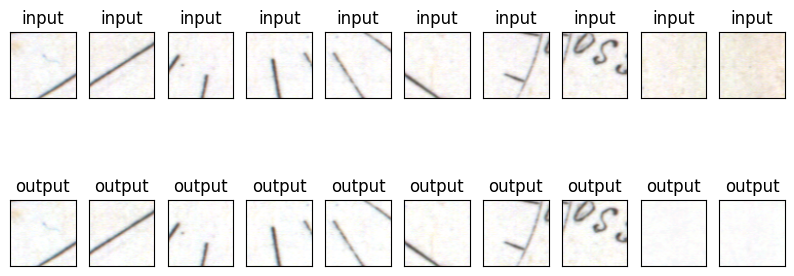

In [4]:

n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):

    ax = plt.subplot(2, n, i + 1)


    plt.title("input")
    plt.imshow((train_input[i+1000]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+1000]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras import layers, losses
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape=(64, 64, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', strides = 2)(inputs)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides = 2)(conv1)

    up6 = concatenate([Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same')(conv2), conv1], axis = -1)

    conv7 = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(up6)

    # Output Layer
    output = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 32, 32, 64)           1792      ['input_11[0][0]']            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 16, 16, 128)          73856     ['conv2d_37[0][0]']           
                                                                                                  
 conv2d_transpose_6 (Conv2D  (None, 32, 32, 128)          147584    ['conv2d_38[0][0]']           
 Transpose)                                                                                 

In [18]:
unet.compile(optimizer='adam', loss=losses.MeanSquaredError())
start_time = time.time()
model = unet.fit(train_input, train_output,
                epochs=epoch,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=4)

# record end time
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'unet_' + str(model_number))

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'loss_'+ str(model_number) + '.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'val_loss_'+ str(model_number) + '.csv')


Epoch 1/100
2997/2997 [==============================] - 21s 6ms/step - loss: 0.0020 - val_loss: 5.8306e-04
Epoch 2/100
2997/2997 [==============================] - 17s 6ms/step - loss: 5.7126e-04 - val_loss: 4.5182e-04
Epoch 3/100
2997/2997 [==============================] - 16s 5ms/step - loss: 5.0723e-04 - val_loss: 4.9227e-04
Epoch 4/100
2997/2997 [==============================] - 17s 6ms/step - loss: 4.6684e-04 - val_loss: 3.9110e-04
Epoch 5/100
2997/2997 [==============================] - 17s 6ms/step - loss: 4.2615e-04 - val_loss: 3.5752e-04
Epoch 6/100
2997/2997 [==============================] - 17s 6ms/step - loss: 3.9405e-04 - val_loss: 3.4732e-04
Epoch 7/100
2997/2997 [==============================] - 17s 6ms/step - loss: 3.9074e-04 - val_loss: 3.8493e-04
Epoch 8/100
2997/2997 [==============================] - 17s 6ms/step - loss: 3.6948e-04 - val_loss: 4.0227e-04
Epoch 9/100
2997/2997 [==============================] - 16s 5ms/step - loss: 3.6112e-04 - val_loss: 3.2875e

NameError: ignored

In [20]:
from tensorflow import keras

n_size = model_number
def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data


#filename = str('[WB] 1885_Mactan_NAP_FelixPelayo.png')
#filename = str("1885_Mactan_NAP_FelixPelayo.tiff")
filename = str("[WB] 1872_Mindanao_NAP_D.FedericoCaballero.tif")
test = Image.open(file_path+ "Testing nbs/" + filename)
test = test.convert('RGB')
w_dirty, h_dirty = test.size


autoencoder = keras.models.load_model(file_path + 'unet_64')


xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)

    neverbeforeseen = np.array(crop_(im1))
    #encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
    decoded_imgs = autoencoder.predict(neverbeforeseen)

    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))

    #y = np.where(col > 0.5,1,0) #round the values
    y= col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

final = np.squeeze(final)
reconstructed = Image.fromarray(final)
reconstructed.save(file_path + "Testing nbs/"+"CLEAN_"+filename)

4/4 [==============================] - 0s 13ms/step


In [ ]:
print(np.shape(final))

(6784, 7872)
